In [12]:
%pip install scipy

import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude


Note: you may need to restart the kernel to use updated packages.


### *1.1 Introductory exercise*

This exercise serves to refresh concepts from the basic image analysis curriculum that will be useful at a later stage in the course.

#### *1.1.1 Image convolution*

Image convolution is a central tool in image analysis. In this exercise, you will investigate properties related to convolution using a Gaussian kernel and its derivatives. For further reading material regarding convolution and filtering, refer to [1], Chapter 5. [2]

For continuous functions $f$ and $g$, convolution is defined as

$$
(f * g)(x) = \int_{-\infty}^{\infty} f(x - \tau) g(\tau) d\tau. \tag{1.1}
$$

Convolution is commutative, but we sometimes distinguish between the signal and the kernel, and we say that the signal is convolved with the kernel. In discrete settings, the equation becomes

$$
(f * g)(x) = \sum_{i=-l}^{l} f(x - i) g(i). \tag{1.2}
$$

In 2D, a convolution with a square kernel is given by

$$
(f * g)(x, y) = \sum_{i=-l}^{l} \sum_{j=-l}^{l} f(x - i, y - j) g(i, j). \tag{1.3}
$$

In image analysis, a Gaussian kernel is often used for image smoothing. The 1D Gaussian with variance $t$ is defined by

$$
g(x; t) = \frac{1}{\sqrt{2t\pi}} e^{-\frac{x^2}{2t}}. \tag{1.4}
$$

Sometimes we parametrize the Gaussian with the standard deviation $\sigma$, where $t = \sigma^2$. The 2D isotropic Gaussian is given by

$$
g(x, y; t) = \frac{1}{2t\pi} e^{-\frac{x^2 + y^2}{2t}}. \tag{1.5}
$$



The Gaussian is separable ([3] Section 5.3.1), which means that convolution with two orthogonal 1D Gaussians yields the same result as convolving with a 2D Gaussian of the same variance. This can significantly speed up convolutions, especially for large kernels.

Another property of the Gaussian convolution is the so-called *semi-group structure*, stating that convolving an image $I$ with a single large Gaussian is equivalent to convolving with several small ones:

$$
g(x, y; t_1 + t_2) * I(x, y) = g(x, y; t_1) * g(x, y; t_2) * I(x, y). \tag{1.6}
$$


On the right part of the equation, the order of convolution does not matter, as convolution is associative.

For an image $I$, we often need to know a local change in intensity values. This can be achieved by taking the spatial derivative. Since the image is a discretely sampled signal, we approximate the derivative, often by computing the difference between neighboring pixels.

When taking the derivative, it is often desirable to remove the noise by smoothing, e.g., using a Gaussian. It turns out that instead of convolving with a Gaussian and then taking the derivative, we can convolve with the derivative of the Gaussian:

$$
\frac{\partial}{\partial x} (I * g) = \frac{\partial I}{\partial x} * g = I * \frac{\partial g}{\partial x}. \tag{1.7}
$$


Since we can compute the derivative of the Gaussian analytically, we get an efficient and elegant approach to computing a smoothed image derivative. The analytic expression for the 1D Gaussian derivative is:

$$
\frac{d}{dx} g(x) = \frac{-x}{\sigma^3 \sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}} = \frac{-x}{t} g(x). \tag{1.8}
$$


The semi-group structure also holds for image derivatives, such that:

$$
\frac{\partial}{\partial x} g(x, y; t_1 + t_2) * I(x, y) = \frac{\partial}{\partial x} g(x, y; t_1) * (g(x, y; t_2) * I(x, y)). \tag{1.9}
$$

This implies that convolving with a large Gaussian derivative yields the same result as convolving with a smaller Gaussian and a smaller Gaussian derivative.

### *Exercise overview*  
We will experimentally test the statements made in the text above. You may use an existing implementation of convolution, e.g., `scipy.ndimage.convolve`. However, refrain from using an existing implementation of the Gaussian filtering or functions returning the Gaussian kernel and its derivative.

### *Data*  
For this exercise, you may use any grayscale image. We have provided an X-ray CT image of fibres `fibres_xcth.png`, shown in Figure **1.1** and Figure **1.2**.

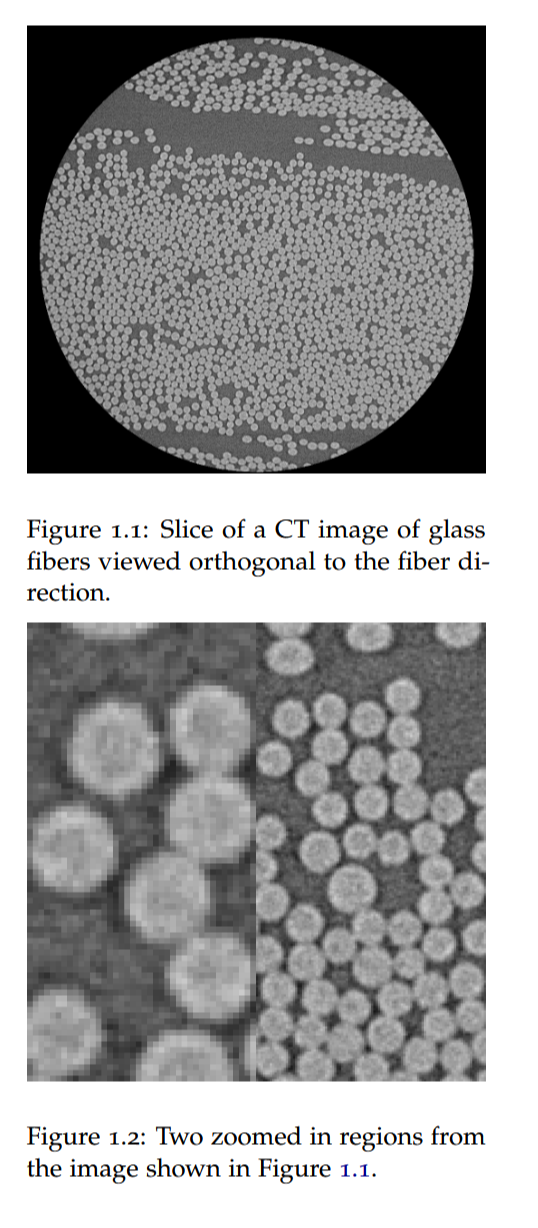


### Tasks

1. **Create Gaussian Kernel**  
   Gaussian kernels are usually truncated at a value between 3 and 5 times $\sigma$. You can create a kernel as follows:

   (a) Compute an integer kernel radius $s$ approximately equal to $4\sigma$.

   (b) Create an array $x$ with integer values centered around 0, that is  
   $x = [-r, \ldots, 0, \ldots, r]$.

   (c) Compute the kernel values using equation 1.4. You may initially compute the values without the normalization term and normalize the kernel to ensure the sum of all values equals 1.

   Verify that your kernel is correct by plotting $x$ against $g$ as shown in **Figure 1.4**. A kernel with the derivative of the Gaussian can be created similarly, and you can see the plot in **Figure 1.5**.


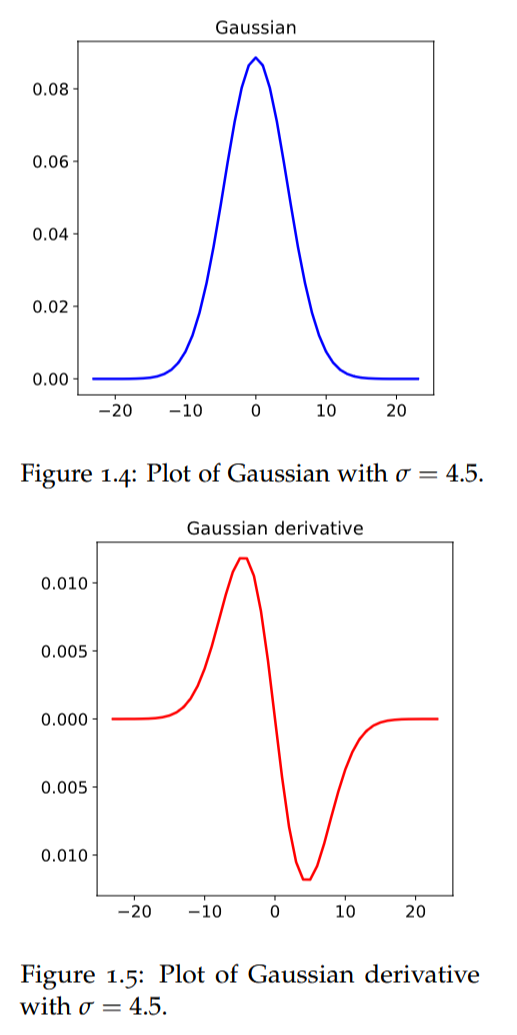


In [2]:
def create_1D_kernel(sigma, x):
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel


def derivative_1D_kernel(sigma, x):
    kernel = -x/(sigma**2) * np.exp(-0.5 * (x/sigma)**2)
    return kernel



Len x: 37


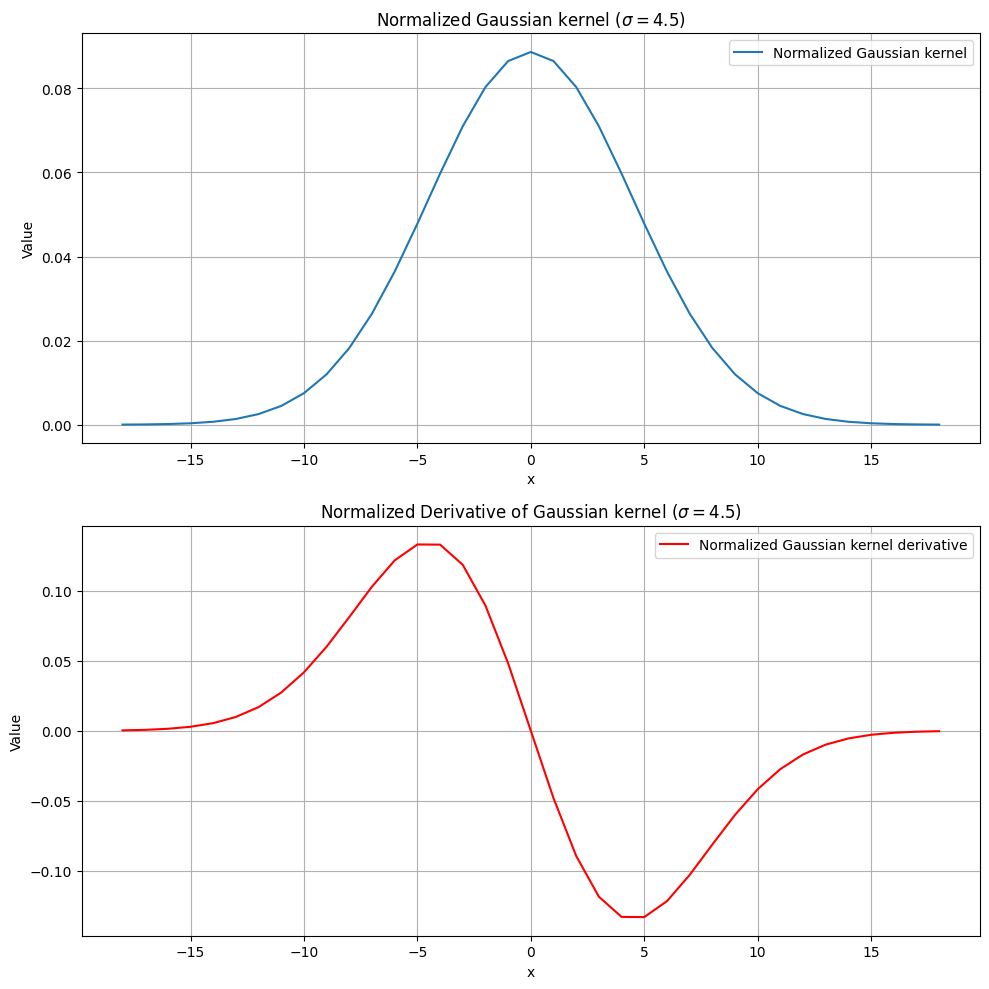

In [3]:
# standard deviation of the Gaussian kernel
SIGMA  = 4.5
N = 4
RADIUS = int(np.ceil(SIGMA * N))

x = np.arange(-RADIUS, RADIUS + 1)

print(f"Len x: {len(x)}")


# create the 1D kernel
kernel_1D = create_1D_kernel(SIGMA , x)
assert np.allclose(kernel_1D.sum(), 1), "Kernel is not normalized"

# create the 1D derivative kernel
kernel_1D_grad = derivative_1D_kernel(SIGMA , x)

# Plot the kernels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot normalized Gaussian kernel
ax[0].plot(x, kernel_1D, label="Normalized Gaussian kernel")
ax[0].set_title(rf"Normalized Gaussian kernel ($\sigma = {SIGMA}$)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Value")
ax[0].grid()
ax[0].legend()

# Plot normalized derivative of Gaussian kernel
ax[1].plot(x, kernel_1D_grad, label="Normalized Gaussian kernel derivative", color="red")
ax[1].set_title(rf"Normalized Derivative of Gaussian kernel ($\sigma = {SIGMA}$)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Value")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

2. **Experimentally Verify the Separability of the Gaussian Kernel**  
   For this, convolve the test image with a 2D Gaussian kernel. Note that you can get a 2D Gaussian kernel as the *outer product* of two 1D kernels. Then, convolve the same test image with two orthogonal 1D kernels. You should get the same result, i.e., after subtracting the two images, the image difference should be small.  

   **Tip**: Use the `'bwr'` colormap to visualize the difference image. Look at the sketch in **Figure 1.6** to understand what you are testing.

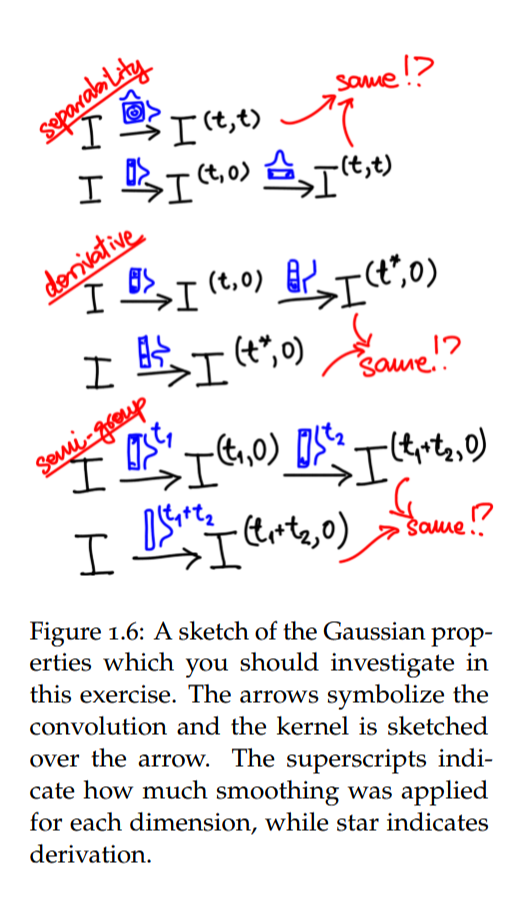

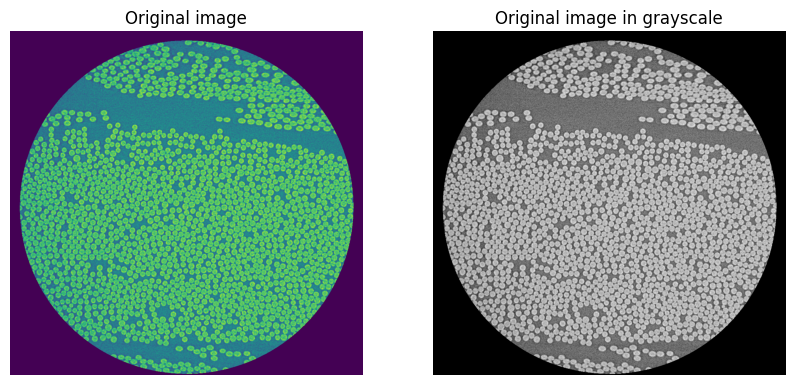

In [14]:
# import image with skimage 
image_origo = skimage.io.imread("data/fibres_xcth.png")
# convert image to grayscale and to float 
#image = skimage.color.rgb2gray(image_origo)

if image_origo.ndim == 3:
    image = skimage.color.rgb2gray(image_origo)
image = skimage.img_as_float(image_origo)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_origo)
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(image, cmap='gray')
ax[1].set_title("Original image in grayscale")
ax[1].axis('off')
plt.show()

Shape of the 2D kernel: (37, 37)


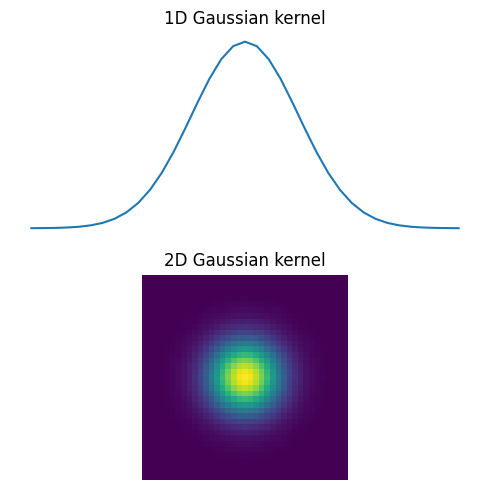

In [25]:
# create 2D kernel by outer product of the 1D kernels
kernel_2d = np.outer(kernel_1D, kernel_1D)
print(f"Shape of the 2D kernel: {kernel_2d.shape}")

# visualize the kernel 
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(kernel_1D)
ax[0].set_title("1D Gaussian kernel")
ax[0].axis('off')
ax[1].imshow(kernel_2d, cmap='viridis')
ax[1].set_title("2D Gaussian kernel")
ax[1].axis('off')
plt.tight_layout()
plt.show()

Shape of the original image: (988, 1013)
Shape of the blurred image: (988, 1013)


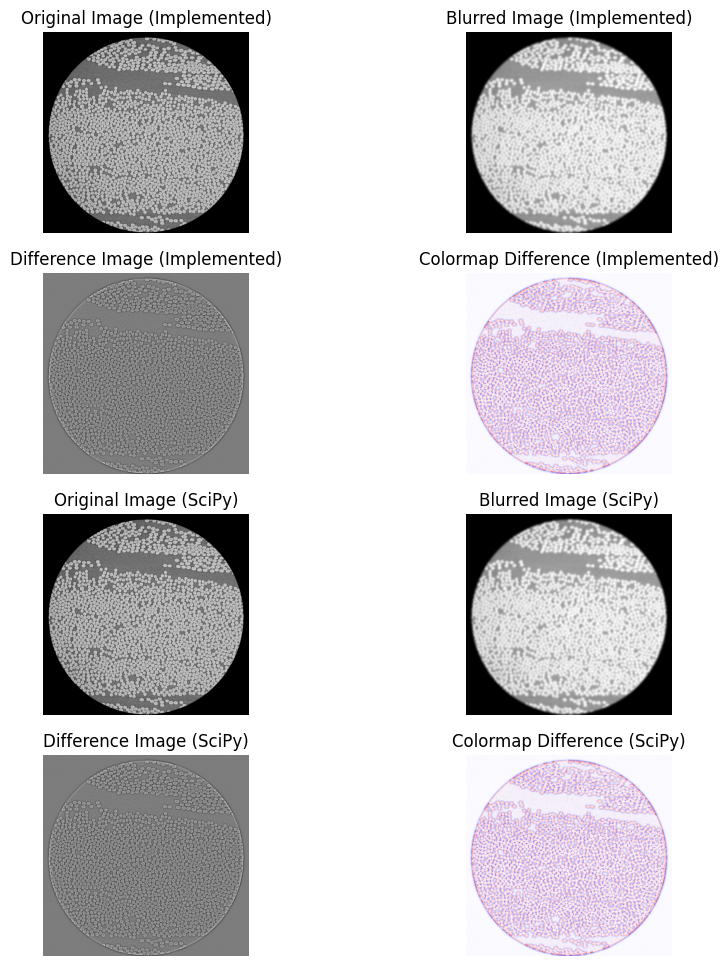

In [ ]:
# applying the 2D gaussian kernel to the image
image_blurred = convolve(image, kernel_2d)
print(f"Shape of the original image: {image.shape}")
print(f"Shape of the blurred image: {image_blurred.shape}")

difference_image = image - image_blurred

# scipy 2d kernel filter 

image_blurred_scipy = gaussian_filter(image, SIGMA)
difference_image_scipy = image - image_blurred_scipy


fig, ax = plt.subplots(4, 2, figsize=(10, 12))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title("Original Image (Implemented)")
ax[0, 0].axis('off')
ax[0, 1].imshow(image_blurred, cmap='gray')
ax[0, 1].set_title("Blurred Image (Implemented)")
ax[0, 1].axis('off')
ax[1, 0].imshow(difference_image, cmap='gray')
ax[1, 0].set_title("Difference Image (Implemented)")
ax[1, 0].axis('off')
ax[1, 1].imshow(difference_image, cmap='bwr')
ax[1, 1].set_title("Colormap Difference (Implemented)")
ax[1, 1].axis('off')
ax[2, 0].imshow(image, cmap='gray')
ax[2, 0].set_title("Original Image (SciPy)")
ax[2, 0].axis('off')
ax[2, 1].imshow(image_blurred_scipy, cmap='gray')
ax[2, 1].set_title("Blurred Image (SciPy)")
ax[2, 1].axis('off')
ax[3, 0].imshow(difference_image_scipy, cmap='gray')
ax[3, 0].set_title("Difference Image (SciPy)")
ax[3, 0].axis('off')
ax[3, 1].imshow(difference_image_scipy, cmap='bwr')
ax[3, 1].set_title("Colormap Difference (SciPy)")
ax[3, 1].axis('off')

#plt.savefig("output/2d_gaussian_blur.png", dpi=300, bbox_inches='tight')
plt.show()

# check if the two methods are equal
assert np.allclose(image_blurred, image_blurred_scipy), "The two methods are not equal"
assert np.allclose(difference_image, difference_image_scipy), "The two methods are not equal"

Shape of the column-wise kernel: (37, 1)
Shape of the image after column-wise convolution: (988, 1013)
Shape of the row-wise kernel: (1, 37)
Shape of the image after row-wise convolution: (988, 1013)
Shape of the image after column-wise convolution (SciPy): (988, 1013)
Shape of the image after row-wise convolution (SciPy): (988, 1013)


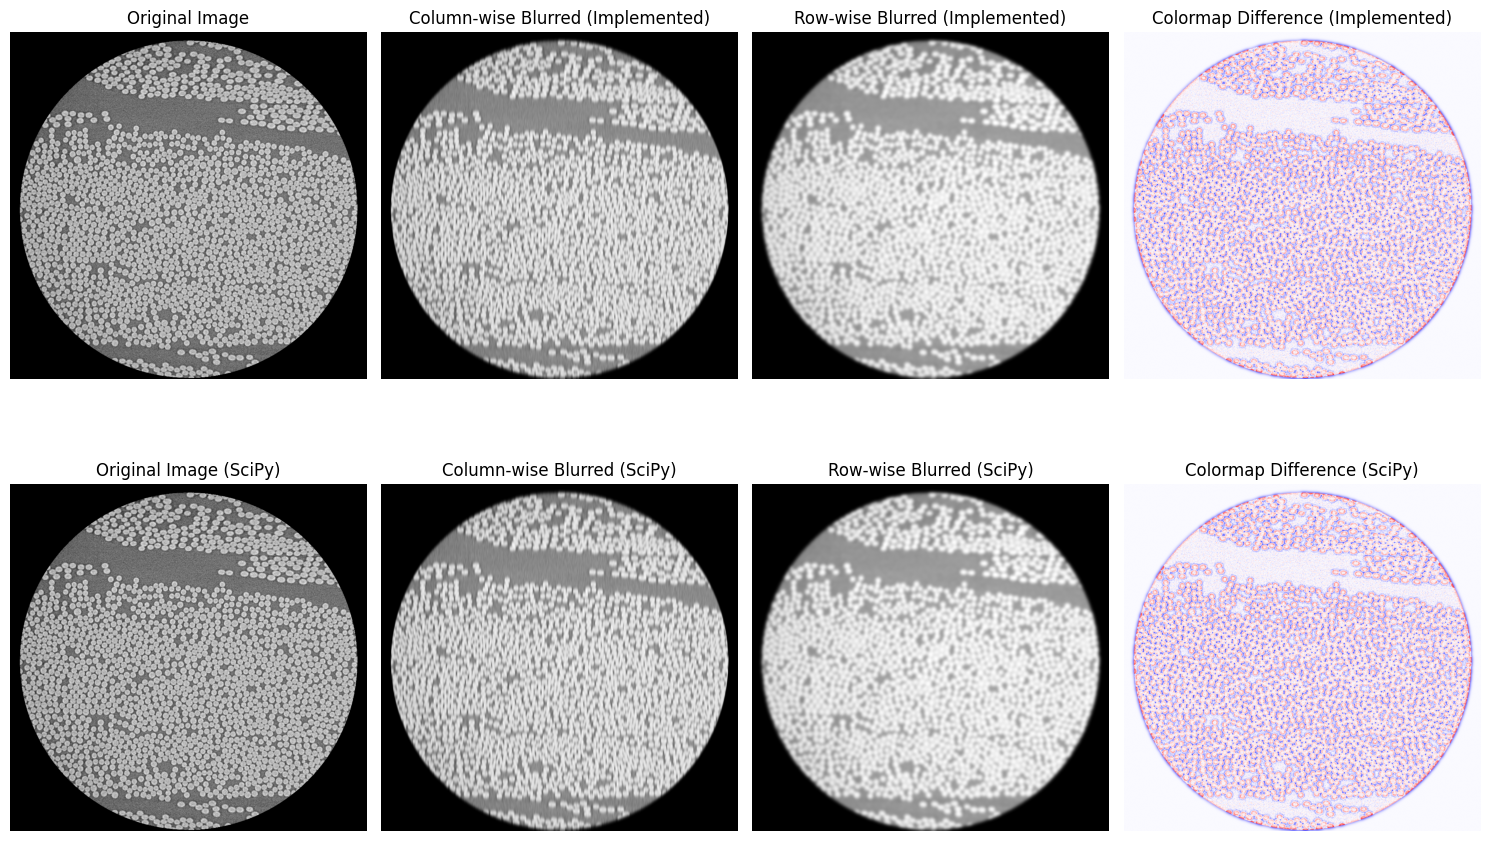

In [33]:
# first convolve the rows 

# convolve column wise
column_wise_gaussian_kernel = kernel_1D.reshape(-1, 1)
print(f"Shape of the column-wise kernel: {column_wise_gaussian_kernel.shape}")
image_columns = convolve(image, column_wise_gaussian_kernel)
print(f"Shape of the image after column-wise convolution: {image_columns.shape}")


# then convolve along the rows 
row_wise_gaussian_kernel = kernel_1D.reshape(1, -1)
print(f"Shape of the row-wise kernel: {row_wise_gaussian_kernel.shape}")
image_rows = convolve(image_columns, row_wise_gaussian_kernel)
print(f"Shape of the image after row-wise convolution: {image_rows.shape}")

# take a difference of origo and the blurred image
difference = image - image_rows


# scipy 

# convolve column wise
image_columns_scipy = gaussian_filter1d(image, SIGMA, axis=0)
print(f"Shape of the image after column-wise convolution (SciPy): {image_columns_scipy.shape}")

# then convolve along the rows
image_rows_scipy = gaussian_filter1d(image_columns_scipy, SIGMA, axis=1)
print(f"Shape of the image after row-wise convolution (SciPy): {image_rows_scipy.shape}")

# take a difference of origo and the blurred image
difference_scipy = image - image_rows_scipy



fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')
ax[0, 1].imshow(image_columns, cmap='gray')
ax[0, 1].set_title("Column-wise Blurred (Implemented)")
ax[0, 1].axis('off')
ax[0, 2].imshow(image_rows, cmap='gray')
ax[0, 2].set_title("Row-wise Blurred (Implemented)")
ax[0, 2].axis('off')
ax[0, 3].imshow(difference, cmap='bwr')
ax[0, 3].set_title("Colormap Difference (Implemented)")
ax[0, 3].axis('off')
ax[1, 0].imshow(image, cmap='gray')
ax[1, 0].set_title("Original Image (SciPy)")
ax[1, 0].axis('off')
ax[1, 1].imshow(image_columns_scipy, cmap='gray')
ax[1, 1].set_title("Column-wise Blurred (SciPy)")
ax[1, 1].axis('off')
ax[1, 2].imshow(image_rows_scipy, cmap='gray')
ax[1, 2].set_title("Row-wise Blurred (SciPy)")
ax[1, 2].axis('off')
ax[1, 3].imshow(difference_scipy, cmap='bwr')
ax[1, 3].set_title("Colormap Difference (SciPy)")
ax[1, 3].axis('off')

plt.tight_layout()
plt.show()


# check if the two methods are equal
assert np.allclose(image_rows, image_rows_scipy), "The two methods are not equal"
assert np.allclose(image_columns, image_columns_scipy), "The two methods are not equal"

3. **Experimentally Verify 1.7**  
   It is enough to test the 1D case. That is, obtain one result by convolving the image with a 1D Gaussian, and take the derivative in the same direction. You can compute the derivative by convolving the image with the kernel $[0.5, 0, -0.5]$.  

   Obtain the second result by convolving the image with the derivative of the Gaussian. Verify that the difference between the two results is small.  

   **Hint**: Compute the average absolute difference between the two images.


##### Convonving the Image with a 1D Gaussian Kernel and then with the Derivative of the Gaussian Kernel

In [15]:
# define the kernel as a column vector
gaussian_kernel_column = kernel_1D.reshape(-1, 1)
print(f"Shape of the column-wise kernel: {gaussian_kernel_column.shape}")

# scipy 1D kernel along the columns
image_blured_columns_scipy = gaussian_filter1d(image, SIGMA, axis=0)

Shape of the column-wise kernel: (37, 1)


Shape of the image after column-wise convolution: (988, 1013)


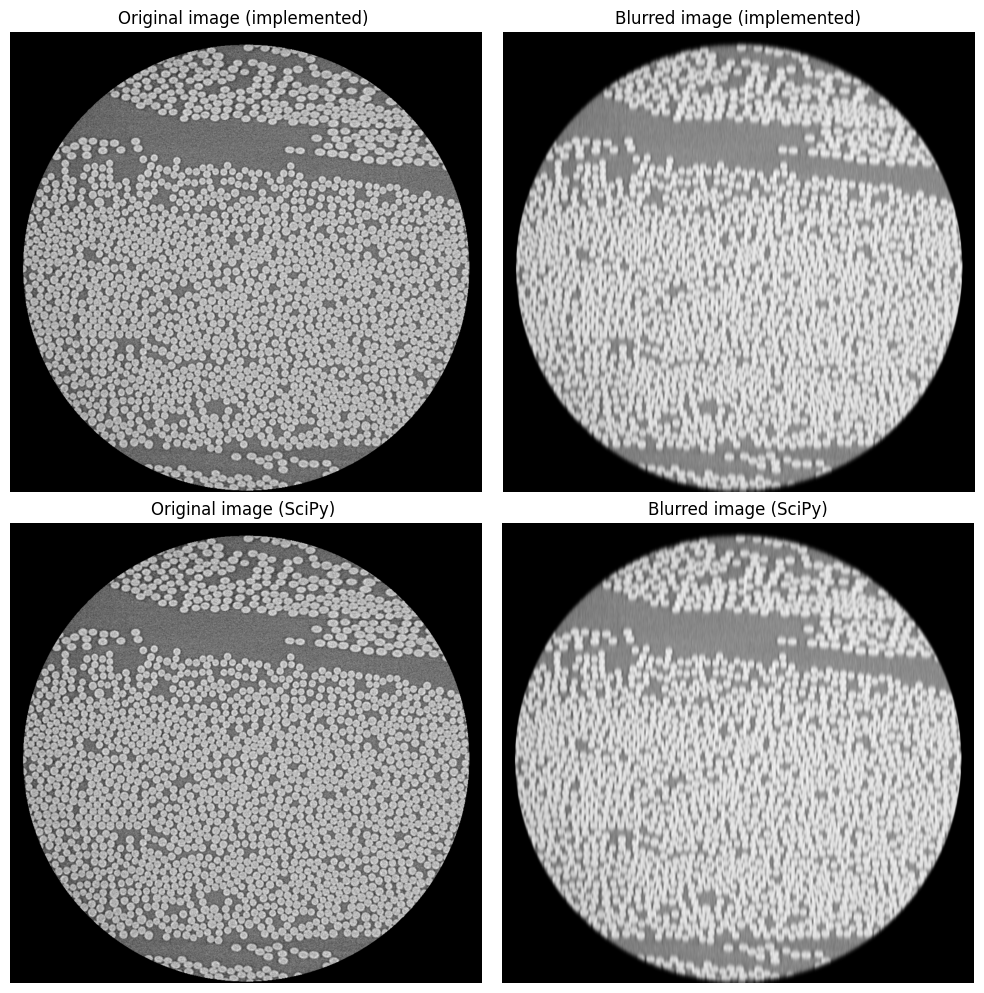

In [16]:
# convolve the image with the kernel
image_blurred_1D_columns = convolve(image, gaussian_kernel_column)
print(f"Shape of the image after column-wise convolution: {image_blurred.shape}")


# visualize the image
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image, cmap='gray')
ax[0][0].set_title("Original image (implemented) ")
ax[0][0].axis('off')
ax[0][1].imshow(image_blurred_1D_columns, cmap='gray')
ax[0][1].set_title("Blurred image (implemented)")
ax[0][1].axis('off')
ax[1][0].imshow(image, cmap='gray')
ax[1][0].set_title("Original image (SciPy) ")
ax[1][0].axis('off')
ax[1][1].imshow(image_columns_scipy, cmap='gray')
ax[1][1].set_title("Blurred image (SciPy)")
ax[1][1].axis('off')
plt.tight_layout()
plt.show()

# check whether the two are equal 
assert np.allclose(image_blured_columns_scipy, image_blurred_1D_columns), "The two methods are not equal"

##### Convonving the Image with a derivative of the Gaussian Kernel

Shape of the derivative kernel: (3, 1)


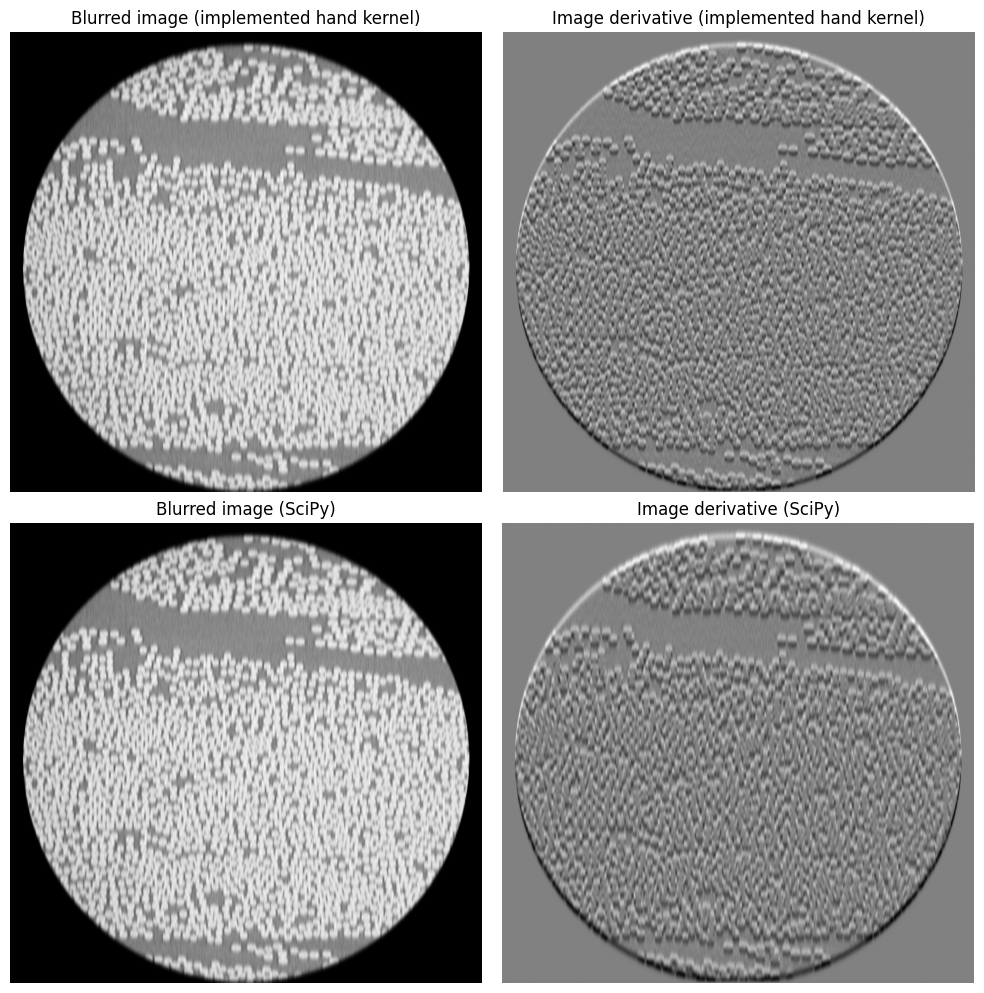

Absolute difference between the two methods: 0.003185315905577831


In [32]:
# derivative of the blurred image 
derivative_kernel = np.array([0.5, 0, -0.5]).reshape(-1, 1)
print(f"Shape of the derivative kernel: {derivative_kernel.shape}")


image_derivative_1D_columns = convolve(image_blurred_1D_columns, derivative_kernel)



# scipy 1D kernel along the columns derivative

image_derivative_1D_columns_scipy = gaussian_filter1d(image_blurred_1D_columns, SIGMA, axis=0, order=1)



fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image_blurred_1D_columns, cmap='gray')
ax[0][0].set_title("Blurred image (implemented hand kernel)")
ax[0][0].axis('off')
ax[0][1].imshow(image_derivative_1D_columns, cmap='gray')
ax[0][1].set_title("Image derivative (implemented hand kernel)")
ax[0][1].axis('off')
ax[1][0].imshow(image_blurred_1D_columns, cmap='gray')
ax[1][0].set_title("Blurred image (SciPy)")
ax[1][0].axis('off')
ax[1][1].imshow(image_derivative_1D_columns_scipy, cmap='gray')
ax[1][1].set_title("Image derivative (SciPy)")
ax[1][1].axis('off')
plt.tight_layout()
plt.show()

# check whether the two are equal
#assert np.allclose(image_derivative_1D_columns, image_derivative_1D_columns_scipy), "The two methods are not equal"

# print absolute difference between the two 
print(f"Absolute difference between the two methods: {np.abs(image_derivative_1D_columns - image_derivative_1D_columns_scipy).mean()}")

# are close withing a tolerance
assert np.allclose(image_derivative_1D_columns, image_derivative_1D_columns_scipy, atol=1e-1), "The two methods are not equal"

#! TODO: ASK TA - why is the difference so large?

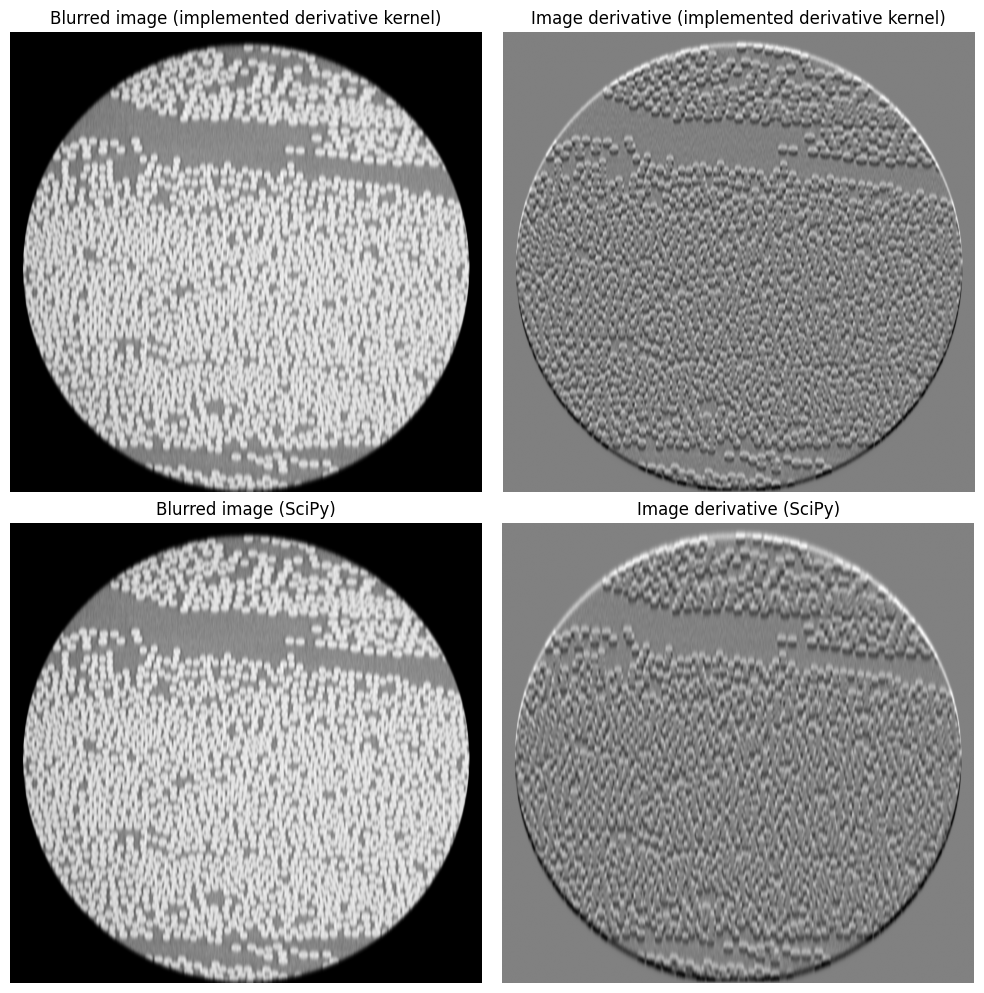

In [37]:
# convolve the image with the derivative kernel
image_derivative_gaussian = convolve(image, kernel_1D_grad.reshape(-1, 1))
# visualize the image derivative (single image)


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image_blurred_1D_columns, cmap='gray')
ax[0][0].set_title("Blurred image (implemented derivative kernel)")
ax[0][0].axis('off')
ax[0][1].imshow(image_derivative_gaussian, cmap='gray')
ax[0][1].set_title("Image derivative (implemented derivative kernel)")
ax[0][1].axis('off')
ax[1][0].imshow(image_blurred_1D_columns, cmap='gray')
ax[1][0].set_title("Blurred image (SciPy)")
ax[1][0].axis('off')
ax[1][1].imshow(image_derivative_1D_columns_scipy, cmap='gray')
ax[1][1].set_title("Image derivative (SciPy)")
ax[1][1].axis('off')
plt.tight_layout()
plt.show()

# check whether the two are equal

assert np.allclose(image_derivative_1D_columns, image_derivative_1D_columns_scipy, atol=1e-1), "The two methods are not equal"
#! TODO: ASK TA - why is the difference so large?


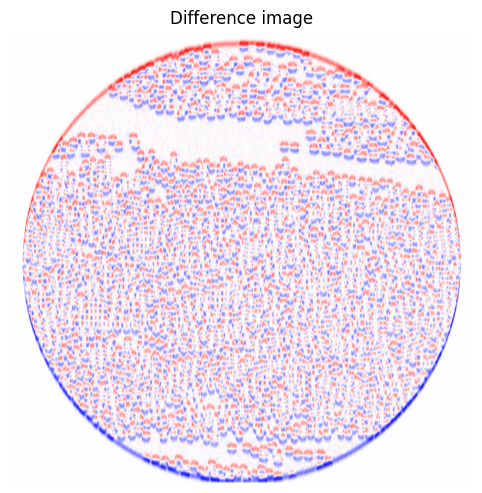

Average absolute difference between the two images: 0.0763


In [38]:
# calculate the difference between the two iamges 

difference_image = image_derivative_gaussian - image_derivative_1D_columns

# visualize the difference image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(difference_image, cmap='bwr')
ax.set_title("Difference image")
ax.axis('off')
plt.tight_layout()
plt.show()

average_absolute_difference = np.mean(np.abs(image_derivative_gaussian - image_derivative_1D_columns))
print(f"Average absolute difference between the two images: {average_absolute_difference:.4f}")

#### Verify that a convolution with a Gausssian of $t = 20$ is equal to ten convolutions with a Gaussian of $t = 2$.. Remember that $sigma = \sqrt(t)$. You can compare the two images by showing the difference image.

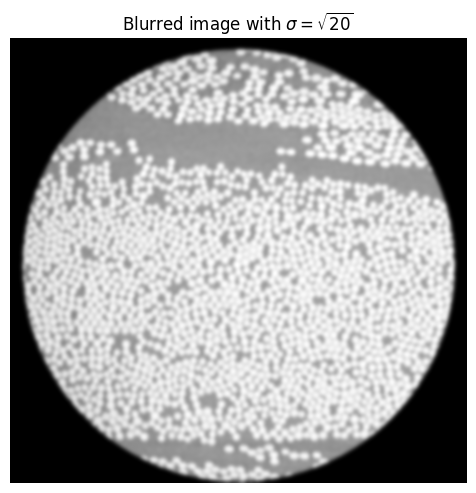

In [39]:
SIGMA_20 = np.sqrt(20)

N_20 = 4
RADIUS_20 = int(N * SIGMA_20)

x_20 = np.arange(-RADIUS_20, RADIUS_20 + 1)


# create the 1D kernel
kernel_1D_20 = create_1D_kernel(SIGMA_20 , x)
assert np.allclose(kernel_1D_20.sum(), 1), "Kernel is not normalized"

# import the same image 
image_20 = skimage.img_as_float(image_origo)

# create 2D kernel by outer product of the 1D kernels
kernel_2d_20 = np.outer(kernel_1D_20, kernel_1D_20)

# applying the 2D gaussian kernel to the image
image_blurred_20 = convolve(image_20, kernel_2d_20, mode='reflect')

# visualize the image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image_blurred_20, cmap='gray')
ax.set_title(r"Blurred image with $\sigma = \sqrt{20}$")
ax.axis('off')
plt.tight_layout()
plt.show()

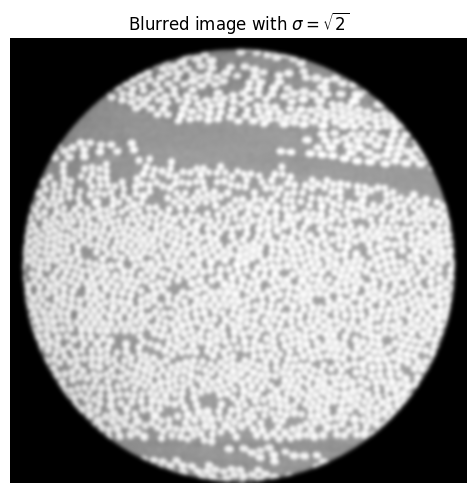

In [347]:
SIGMA_2 = np.sqrt(2)

N_2 = 4
RADIUS_2 = int(N_2 * SIGMA_2)

x_2 = np.arange(-RADIUS_2, RADIUS_2 + 1)


# create the 1D kernel
kernel_1D_2 = create_1D_kernel(SIGMA_2 , x_2)
assert np.allclose(kernel_1D_2.sum(), 1), "Kernel is not normalized"

# import the same image 
image_2= skimage.img_as_float(image_origo)

# create 2D kernel by outer product of the 1D kernels
kernel_2d_2 = np.outer(kernel_1D_2, kernel_1D_2)

# apply 10 convilutions with the kernel

for _ in range(10):
    image_2 = convolve(image_2, kernel_2d_2, mode='reflect')

# visualize the image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image_2, cmap='gray')
ax.set_title(r"Blurred image with $\sigma = \sqrt{2}$")
ax.axis('off')
plt.tight_layout()
plt.show()


Shape of the difference image: (988, 1013)
Absolute difference between the two images: 20.3765
Average absolute difference between the two images: 0.0000


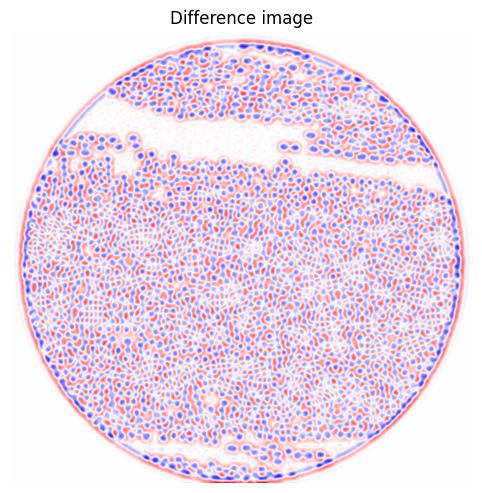

Original image shape: (988, 1013)
Image after 10 convolutions shape: (988, 1013)
Image after single convolution shape: (988, 1013)


In [353]:
# calculate the difference between the two images 

difference_image = image_blurred_20 - image_2
print(f"Shape of the difference image: {difference_image.shape}")

# absolute difference
absolute_difference = np.abs(difference_image).sum()
print(f"Absolute difference between the two images: {absolute_difference:.4f}")

# absolute mean difference 
average_absolute_difference = np.mean(np.abs(image_blurred_20 - image_2))
print(f"Average absolute difference between the two images: {average_absolute_difference:.4f}")


# visualize the difference image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(difference_image, cmap='bwr')
ax.set_title("Difference image")
ax.axis('off')
plt.tight_layout()
plt.show()


print(f"Original image shape: {image_origo.shape}")
print(f"Image after 10 convolutions shape: {image_2.shape}")
print(f"Image after single convolution shape: {image_blurred_20.shape}")


##### Verify that a convolution with a Gaussian derivative of $t = 20$ is equal to convolving with a Gaussian of $t = 10$ and a Gaussian derivative of $t = 10$. 

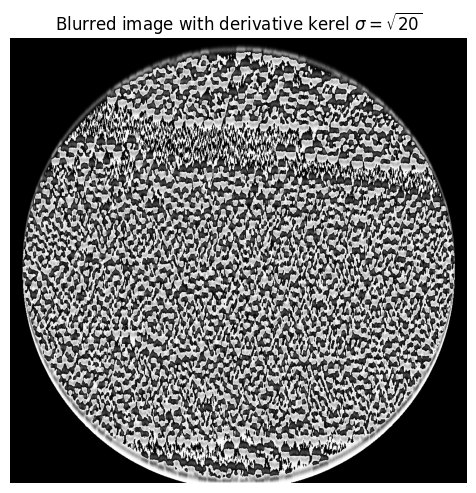

In [359]:
# gaussian derivative with t = 20 

SIGMA_DER_20 = np.sqrt(20)

N_DER_20 = 4

RADIUS_DER_20 = int(N_DER_20 * SIGMA_DER_20)

x_der_20 = np.arange(-RADIUS_DER_20, RADIUS_DER_20 + 1)

# create the 1D kernel
kernel_1D_der_20 = derivative_1D_kernel(SIGMA_DER_20 , x_der_20)


# applying the 2D gaussian kernel to the image
image_blurred_der_20 = convolve(image_origo, kernel_1D_der_20.reshape(-1, 1), mode='reflect')

# visualize the image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image_blurred_der_20, cmap='gray')
ax.set_title(r"Blurred image with derivative kerel $\sigma = \sqrt{20}$")
ax.axis('off')
plt.tight_layout()
plt.show()


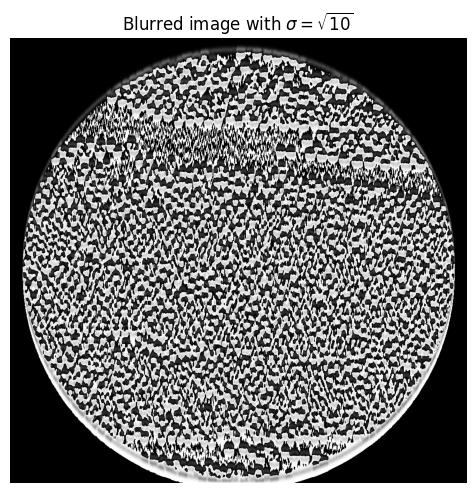

In [360]:
# gaussian t = 10 

SIGMA_10 = np.sqrt(10)

N_10 = 4

RADIUS_10 = int(N_10 * SIGMA_10)

x_10 = np.arange(-RADIUS_10, RADIUS_10 + 1)

# create the 1D kernel
kernel_1D_10 = create_1D_kernel(SIGMA_10 , x_10)

# create 1D derivative kernel
kernel_1D_grad_10 = derivative_1D_kernel(SIGMA_10 , x_10)

# applying the 2D gaussian kernel to the image
image_blurred_10 = convolve(image_origo, kernel_1D_10.reshape(-1, 1), mode='reflect')

# now convolution with the derivative kernel

image_blurred_10 = convolve(image_blurred_10, kernel_1D_grad_10.reshape(-1, 1), mode='reflect')

# visualize the image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image_blurred_10, cmap='gray')
ax.set_title(r"Blurred image with $\sigma = \sqrt{10}$")
ax.axis('off')
plt.tight_layout()
plt.show()
